# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [77]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import matplotlib
import copy
from tqdm import tqdm

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
from decision_tree_implementation import DecisionTreeClassifier

In [19]:
class RandomForestClassifier:
    
    class DecisionTree:
        def __init__(self, features_size, criterion, max_depth, min_samples_leaf, splitter):
            self.features_size = features_size
            self.criterion = criterion
            self.max_depth = max_depth
            self.min_samples_leaf = min_samples_leaf 
            self.splitter = splitter
        def fit(self, X, y):
            self.features_indices = random.sample(range(len(X.columns)), k = self.features_size(len(X.columns)))
            X = X.copy()
            X = X.iloc[:, self.features_indices]
            self.clf = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, 
                                              min_samples_leaf=self.min_samples_leaf, splitter=self.splitter)
            self.clf.fit(X, y)
        def predict(self, X):
            X = X.copy()
            X = X.iloc[:, self.features_indices]   
            return self.clf.predict(X)                                      
            
            
    def __init__(self, n_trees=10, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", splitter="best"):
        if max_features is None:
            self.features_size = lambda x: round(x)
        elif max_features == 'auto' or max_features == 'sqrt':
            self.features_size = lambda x: round(math.sqrt(x))
        elif max_features == 'log2':
            self.features_size = lambda x: round(math.log2(x))
        elif max_features < 1:
            self.features_size = lambda x: round(max_features * x)
        else:
            self.features_size = lambda x: round(max_features)
        
        self.n_trees = n_trees
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.splitter = splitter
                                                  
    def fit(self, X, y):
        self.trees = []
        self.trees_indices = []
        self.X = X
        self.y = y
        for i in range(self.n_trees):
            classifier = self.DecisionTree(self.features_size, self.criterion, self.max_depth, self.min_samples_leaf, self.splitter)
            
            indices = [random.choice(range(len(X))) for _ in range(len(X))]
            X_data = X.iloc[indices]
            y_data = y.iloc[indices]
            
            classifier.fit(X_data, y_data)
            self.trees.append(classifier)
            self.trees_indices.append(indices)
        oob = []
        for index, row in X.iterrows():
            oob_sum = 0
            oob_all = 0
            for tree, tree_indices in zip(self.trees, self.trees_indices):
                if index not in tree_indices:
                    predicted = tree.predict(X.loc[[index]])
                    oob_all += 1
                    oob_sum += predicted[0]
            if oob_all != 0:
                oob.append(1 if round(oob_sum / oob_all) == y.at[index] else 0)
            else:
                oob.append(0)
        self.oob_error = sum(oob) / len(X.index) 
                                                  
    def predict(self, X):
        predicted = []
        for tree in self.trees:
            predicted.append(tree.predict(X))
        predicted = np.array(predicted)
        y_pred = []
        for column in predicted.T:
            frequency_array = np.bincount(column)
            y_pred.append(np.argmax(frequency_array))
        return np.array(y_pred)
                       
    def predict_proba(self, X):
        predicted = []
        for tree in self.trees:
            predicted.append(tree.predict(X))
        predicted = np.array(predicted)
        y_pred = []
        for column in predicted.T:
            p = np.mean(column)
            y_pred.append({1: p, 0: 1 - p})
        return y_pred

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [4]:
def hyperparameter_optimization(X, y):
    best_score = -1
    best_params = None
    kf = KFold()
    splits = [(train, test) for train, test in kf.split(X)]
    for d in [2, 3, 5, 7, 10]:
        for count in [5, 10, 20, 30, 50, 100]:
            scores = []
            for train_index, test_index in splits:
                tree = RandomForestClassifier(max_depth=d, n_trees=count, splitter="random")
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                tree.fit(X_train, y_train)
                y_pred = tree.predict(X_test)
                scores.append(roc_auc_score(y_test, y_pred))
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_params = {'depth': d, 'n_trees': count, 'clf': tree}
                print(f'Finished with roc_auc-score {score} for depth {d} and n-trees {count}')
    return best_score, best_params

In [5]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    y = y.replace({'M': 1, 'B': 0})
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.1)

In [7]:
auc, best_params = hyperparameter_optimization(X_train, y_train)
print(f'Best auc is {auc} for params: depth -- {best_params["depth"]}, n_trees -- {best_params["n_trees"]}')

Finished with roc_auc-score 0.8949821688459458 for depth 2 and n-trees 5
Finished with roc_auc-score 0.8985766981556456 for depth 2 and n-trees 20
Finished with roc_auc-score 0.9051798727588201 for depth 2 and n-trees 100
Finished with roc_auc-score 0.9105935048783346 for depth 3 and n-trees 10
Finished with roc_auc-score 0.9147828545723284 for depth 3 and n-trees 30
Finished with roc_auc-score 0.9227195552985027 for depth 3 and n-trees 50
Finished with roc_auc-score 0.9251108767393598 for depth 5 and n-trees 5
Finished with roc_auc-score 0.9254104491999229 for depth 5 and n-trees 10
Finished with roc_auc-score 0.9383162393162394 for depth 5 and n-trees 30
Best auc is 0.9383162393162394 for params: depth -- 5, n_trees -- 30


In [8]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

AUC score: 0.9614864864864866
Accuracy score: 0.9649122807017544


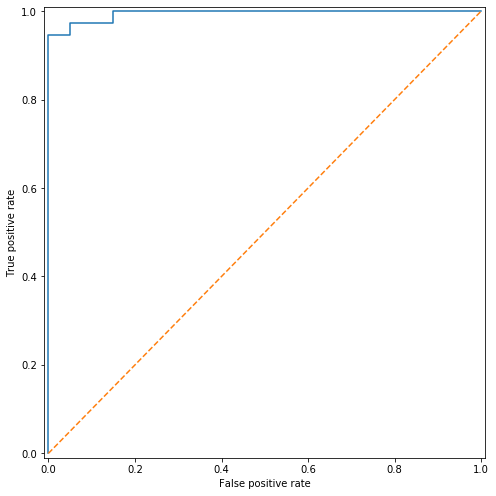

In [11]:
clf = RandomForestClassifier(max_depth=best_params["depth"], n_trees=best_params["n_trees"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
p_pred = clf.predict_proba(X_test)
print(f'AUC score: {roc_auc_score(y_pred, y_test)}')
print(f'Accuracy score: {accuracy_score(y_pred, y_test)}')
plot_roc_curve(y_test, p_pred)

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [78]:
def feature_importance(rfc):
    oob = []
    X = rfc.X
    y = rfc.y
    start_oob = rfc.oob_error
    for name in tqdm(X.columns):
        X_copy = copy.deepcopy(X)
        X_copy[name] = X_copy[name].sample(frac=1).reset_index(drop=True)
        rfc.fit(X_copy, y)
        oob.append(round(start_oob - rfc.oob_error, 2))
    return oob

def most_important_features(importance, names=None, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    if names is None:
        return idicies
    else:
        return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [82]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2),int(i % 6 == 3), 
          int(i % 6 == 0), int(i % 3 == 2), np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return pd.DataFrame(X, columns=[str(i) + '_c' for i in range(6)]), pd.Series(y)

X, y = synthetic_dataset(100)
rfc = RandomForestClassifier(n_trees=100, max_features=None)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Accuracy: 1.0


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:00<00:00, 10.03s/it]

Importance: [0.0, 0.0, 0.21, 0.24, 0.47, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [83]:
rfc = RandomForestClassifier(splitter="random")
rfc.fit(X_cancer, y_cancer)
print("Most important features: ", most_important_features(feature_importance(rfc), k=10))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:29<00:00,  4.98s/it]

Most important features:  [12 23  3  6  9 28 29 15  1  7]


In [79]:
rfc = RandomForestClassifier(splitter="random", min_samples_leaf=50) # too long without the leaf size truncating 
rfc.fit(X_spam, y_spam)
print("Most important features: ", most_important_features(feature_importance(rfc), k=10))

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [21:58<00:00, 23.12s/it]

Most important features:  [ 7 12 44 35 14  6 10 16 32 28]


### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [39]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=f9c5e1d711ef51a9ed913fbee49c594986ea8116fb6d5a7beec623edba59b12b
  Stored in directory: c:\users\lizzka239\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [47]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBRegressor

_CatBoost сильно проигрывает по скорости обучения, но с учетом того, что наши наборы данных достаточно маленькие, мы можем на это не сильно обращать внимание, при этом эта модель выдает чуть лучшие метрики, поэтому я бы брала ее как самую подходящую под нашу задачу._

In [74]:
def train_data_clf(X_train, X_test, y_train, y_test, clf, name):
    clf = clf()
    %time clf.fit(X_train, y_train, verbose=False)
    
    y_pred = clf.predict(X_test)
    if name == 'xgboost':
        p_pred = [{1: x, 0: 1 - x} for x in y_pred]
    else:
        p_pred = clf.predict_proba(X_test)
        p_pred = [{0: x[0], 1: x[1]} for x in p_pred]
    y_pred = [round(x) for x in y_pred]
    print(f'AUC score: {roc_auc_score(y_pred, y_test)}')
    print(f'Accuracy score: {accuracy_score(y_pred, y_test)}')
    plot_roc_curve(pd.Series(y_test), p_pred)
    plt.show()

Training lightgbm
Wall time: 85.8 ms
AUC score: 0.9495670995670996
Accuracy score: 0.9415204678362573


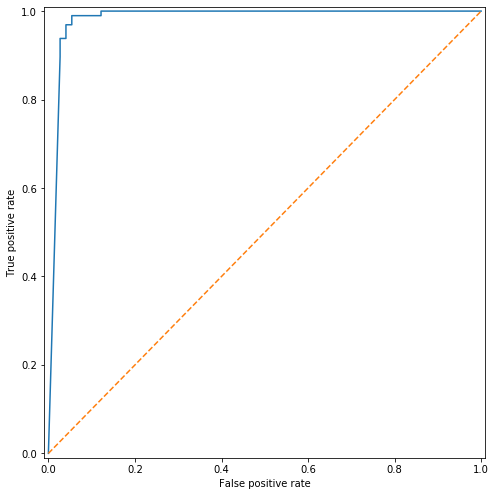

--------------------
Training catboost
Wall time: 4.2 s
AUC score: 0.9633418584825234
Accuracy score: 0.9590643274853801


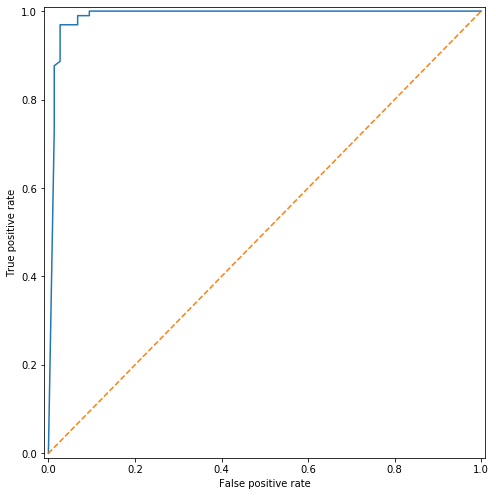

--------------------
Training xgboost
Wall time: 94.8 ms
AUC score: 0.9318246110325319
Accuracy score: 0.9298245614035088


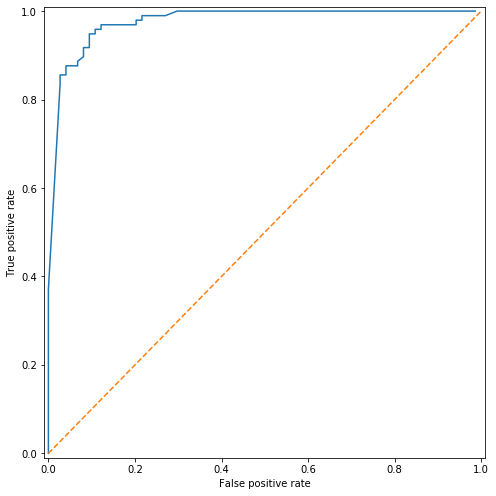

--------------------


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.3)
for classifier, name in [(lgb.LGBMClassifier, 'lightgbm'), (CatBoostClassifier, 'catboost'), (XGBRegressor, 'xgboost')]:
    print(f"Training {name}")
    train_data_clf(X_train, X_test, y_train, y_test, classifier, name)
    print("--------------------")

Training lightgbm
Wall time: 383 ms
AUC score: 0.948545841694342
Accuracy score: 0.9514844315713251


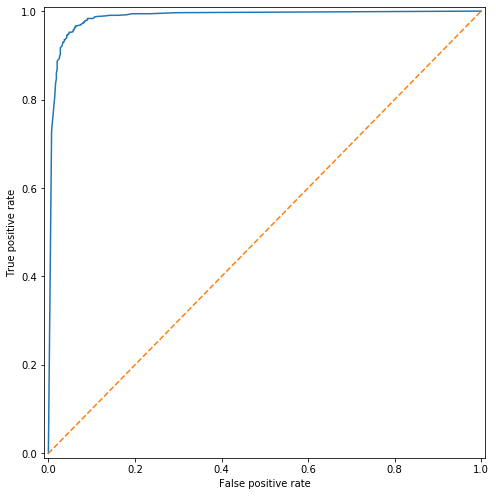

--------------------
Training catboost
Wall time: 12.7 s
AUC score: 0.9500584905495044
Accuracy score: 0.9529326574945691


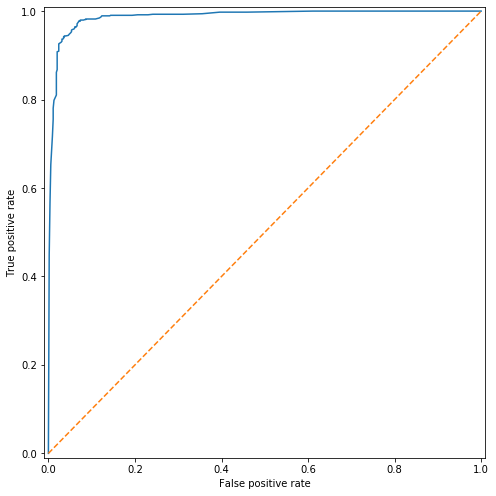

--------------------
Training xgboost
Wall time: 519 ms
AUC score: 0.9407023508711586
Accuracy score: 0.942795076031861


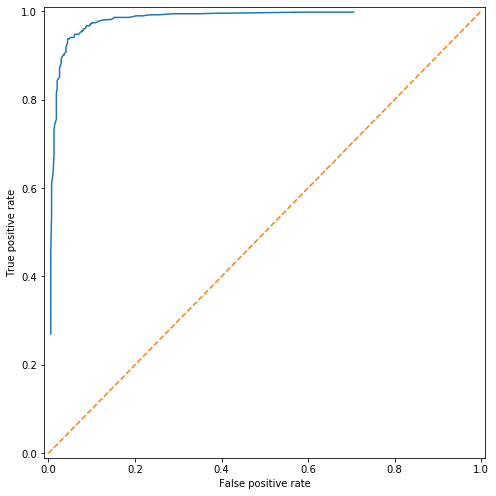

--------------------


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.3)
for classifier, name in [(lgb.LGBMClassifier, 'lightgbm'), (CatBoostClassifier, 'catboost'), (XGBRegressor, 'xgboost')]:
    print(f"Training {name}")
    train_data_clf(X_train, X_test, y_train, y_test, classifier, name)
    print("--------------------")